# Observational analysis of gender repartition in the cinema
The goal of this study is to observe the gender repartition in the cinema and to try to understand where the inequalities come from.
The observation will be done over the age of the actors, the movies' genre, country and over a certain period of time.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
import ast
from statsmodels.stats import diagnostic
from scipy import stats


In [3]:
# open the files
movie_df = pd.read_csv('./data/movie_metadata.csv', sep=',', encoding='utf-8', on_bad_lines='skip').drop_duplicates()
char_df=pd.read_csv('./data/character_metadata.csv', sep=',', encoding='utf-8', on_bad_lines='skip').drop_duplicates()

## Data preprocessesing

In [4]:
# Drop null values in gender column
char_df.dropna(subset=['Actor gender'], inplace=True)
# Drop bi-gender association for each actor ID in character
bi_gender=char_df.groupby('Freebase actor ID')['Actor gender'].transform('nunique')>1
char_df= char_df[~bi_gender]

In [5]:
# Select movies with actors we know the genders (common movies between charactere and movie dataframes)
movie_filtered=movie_df[movie_df['Freebase movie ID'].isin(char_df['Freebase movie ID'])]
#print('Number of movies :', movie_filtered['Freebase movie ID'].nunique())

# Associate charactere and movie dataframes on movie ID
char_movie=pd.merge(char_df, movie_filtered, on='Freebase movie ID', how='inner')

# Naïve analysis of gender repartition

The proportion of actresses over the whole population of actors is 36.83%


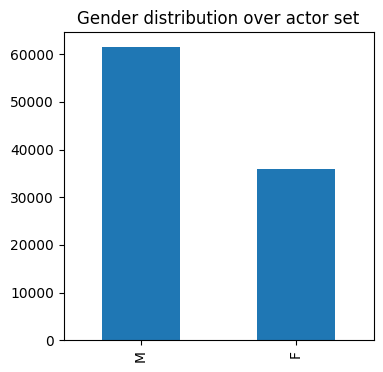

In [6]:
# Proportion of women in the actors data set
#Drop duplicates in actor ID column
gender_actors=char_df[['Freebase actor ID','Actor gender']].dropna().drop_duplicates(subset='Freebase actor ID')
# Count the number of actors
number_actresses=gender_actors[gender_actors['Actor gender']=='F'].count()
proportion_women=number_actresses/gender_actors['Freebase actor ID'].count()

# Print actor gender distribution over actor set
gender_actors["Actor gender"].value_counts().plot(kind='bar', title ='Gender distribution over actor set', figsize=(4,4))

print(f'The proportion of actresses over the whole population of actors is {proportion_women[0]:.2%}')

## Analysis of gender over actor age at movie release

Text(0.5, 1.0, 'Distribution of age repartition over actors')

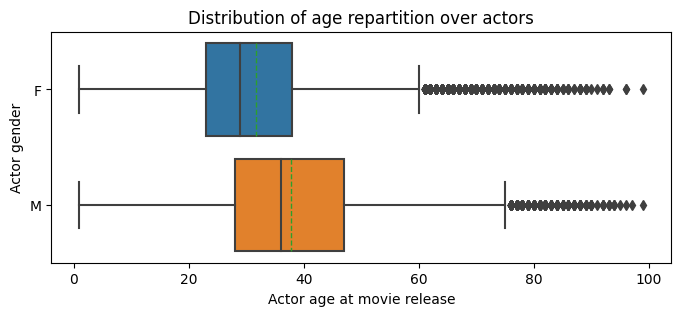

In [7]:
#Drop null values for the age column, drop duplicates in actor ID column
gender_age=char_df[['Freebase actor ID','Actor age at movie release','Actor gender']].dropna().drop_duplicates(subset='Freebase actor ID')
#Drop negative values for age
gender_age['Actor age at movie release']=gender_age['Actor age at movie release'].apply(lambda x: x if x>0 else None).dropna()

# Print distribution of age repartition over actors
plt.figure(figsize=(8,3))
sns.boxplot(y='Actor gender', x='Actor age at movie release', data=gender_age, showmeans=True, meanline=True)
plt.title('Distribution of age repartition over actors')

#### **Comment**

As we can observe, the average age of the actresses is lower than the average age of the actors. 
Observing the proportion of actressess over the actors population could indicate if this last distribution is not due to a lack of representativeness in the actresses population

The proportion of women is 37.66% in the total actor population. This tells us that the cinema industry is quite unbalance in terms of gender repartition.
What would be interesting now would be to study what are the factors that influence such a disparity.
The following part will try to assess the influence of the time and of the country of the movie on the gender repartition.

Moreover, it would also to be interesting to know if the age plays a role in the female proportion of the actors

In [8]:
#create a df grouped by age and the corresponding male and female counts for that runtime
gender_age_dist = gender_age.groupby('Actor age at movie release').agg(Female_counts = ('Actor gender', lambda x: (x == 'F').sum()),
                                                         Male_counts = ('Actor gender', lambda x: (x == 'M').sum())).reset_index()

In [9]:
gender_age_dist

,Actor age at movie release,Female_counts,Male_counts
0,1.0,4,8
1,2.0,15,8
2,3.0,12,14
3,4.0,20,11
4,5.0,20,28
...,...,...,...
93,94.0,0,3
94,95.0,0,1
95,96.0,2,1
96,97.0,0,1


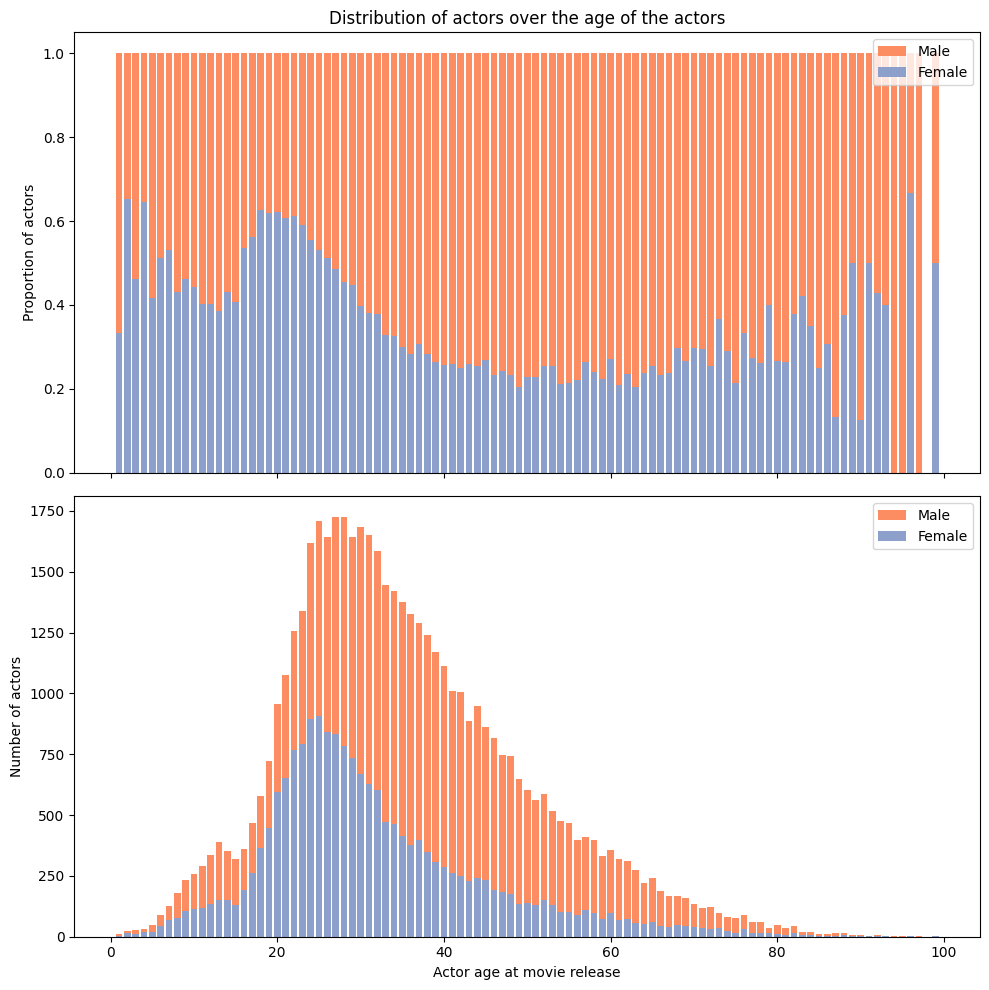

In [10]:
#plot the number of female and male counts over the runtime of each movie
fig, ax = plt.subplots(figsize=(10,10), sharex=True, nrows=2, ncols=1)
bar1 = ax[0].bar(gender_age_dist['Actor age at movie release'], 
              gender_age_dist['Male_counts']/(gender_age_dist['Male_counts']+gender_age_dist['Female_counts']), 
              label = 'Male', color='#fc8d62', 
              bottom = gender_age_dist['Female_counts']/(gender_age_dist['Male_counts']+gender_age_dist['Female_counts']))
bar2 = ax[0].bar(gender_age_dist['Actor age at movie release'], gender_age_dist['Female_counts']/(gender_age_dist['Male_counts']+gender_age_dist['Female_counts']) 
              , label = 'Female', color='#8da0cb',)

#ax[0].set_xlabel('Actor age at movie release')

ax[0].set_ylabel('Proportion of actors')
ax[0].set_title('Distribution of actors over the age of the actors')
ax[0].legend()

bar3 = ax[1].bar(gender_age_dist['Actor age at movie release'], 
              gender_age_dist['Male_counts'], 
              label = 'Male', color='#fc8d62', 
              bottom = gender_age_dist['Female_counts'])
bar4 = ax[1].bar(gender_age_dist['Actor age at movie release'], gender_age_dist['Female_counts'], label = 'Female', color='#8da0cb',)
ax[1].set_xlabel('Actor age at movie release')

ax[1].set_ylabel('Number of actors')
ax[1].legend()

plt.tight_layout()
plt.show()

#### **Comment**

We can observe from the above plot that there is a lot of variation in the proportion of female actors depending on the age of the actor. Even though in general the dataset consists of around 37% female actors, we observe that for ages between 5 and 40 there is in average a similar proportion of female actors to male actors, whereas between 40 and 70 years old, the average proportion of female actors decreases to around 30% ( we leave aside the population over 70 because the number of actors becomes too small).   
Therefore in order to study more cofounders of the gender distribution in the rest of the project, we can split the population in two categories, under and over 40 y.o. 
We could apply different methodologies of sample balancing for those two categories for example exact matching for the first category and bootstrapping for the second.


## Analysis of gender repartition over movies country

The gender repartition in a movie can be influenced by the culture. 
We decided to select the most common movie country for each continent. This ensure to have the most amount of movies, and to have a wide diversity of cultures.  

In [11]:
#Select most common countries for movies
top_countries=movie_filtered['Countries'].value_counts().head(20).index
print('Top 20 countries :', movie_filtered['Countries'].value_counts().head(20))

Top 20 countries : ['United States of America']                      26042
['India']                                          7414
[]                                                 4939
['United Kingdom']                                 3816
['Japan']                                          1632
['France']                                         1348
['Italy']                                          1166
['Canada']                                          972
['United States of America', 'United Kingdom']      797
['Hong Kong']                                       778
['South Korea']                                     669
['United States of America', 'Canada']              586
['Germany']                                         498
['France', 'Italy']                                 451
['Australia']                                       450
['Spain']                                           388
['Mexico']                                          369
['Argentina']                

#### **Comment**

According to the very low number of movies for South america, it was decided to take two countries to make sure to have enough samples compared with the other continents. Africa was not taken into account due to its insufficient number of movies. <br/>
The most common movie country for each continent are: <br/>
North america: United States <br/>
Central America: Mexico <br/>
South Americal: Argentina <br/>
Europe: United Kingdoms <br/>
Asia: India <br/>


We are now going to observe the gender distribution in movies over each country

In [12]:
most_common_country=[top_countries[0],top_countries[1],top_countries[3],top_countries[16],top_countries[17]]
#select movies with most common countries
gender_country=char_movie[char_movie['Countries'].isin(most_common_country)][['Freebase actor ID', 'Actor gender','Countries','Freebase movie ID']].dropna()

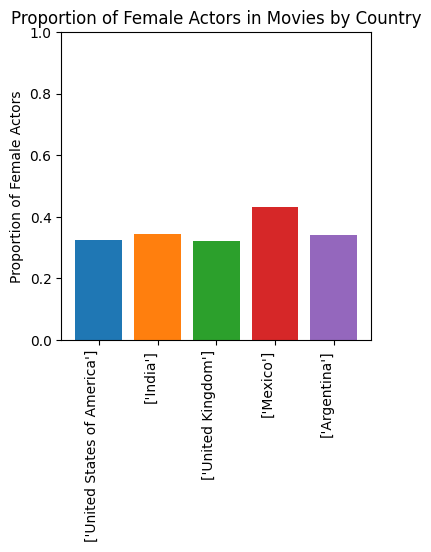

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

#loop through each country and plot the proportion of female actors
for i, country in enumerate(most_common_country):
    country_data = gender_country[gender_country['Countries'] == country]
    #calculate the proportion of female actors
    total_actors = len(country_data)
    proportion_female = country_data['Actor gender'].value_counts(normalize=True).get('F', 0)
    #plot the proportion of female actors for each country
    ax.bar(i, proportion_female, label=country)

ax.set_xticks(range(len(most_common_country)))
ax.set_xticklabels(most_common_country, rotation=90, ha='right')

ax.set_ylabel('Proportion of Female Actors')
ax.set_ylim(0, 1)

plt.title('Proportion of Female Actors in Movies by Country')
plt.show()

As a conclusion, the gender repartion is also inequal no matter the culture or the continent.
We can observe 

## Analysis of gender repartition over numbers of actors per movie

In [14]:
#find how many actors play in each movie
actor_counts = char_movie.groupby('Freebase movie ID')['Freebase actor ID'].count()
character_counts = char_movie.groupby('Freebase movie ID')['Freebase character ID'].count()
actor_counts.rename('Actor counts', inplace=True)
#percentage of females for each sum of characters in each movie
perc_female = char_movie.groupby('Freebase movie ID')['Actor gender'].apply(lambda x: (x == 'F').sum()/x.count())
fig_df = pd.merge(actor_counts, perc_female, on='Freebase movie ID')

Text(0.5, 1.0, 'Female percentage vs number of actors per movie')

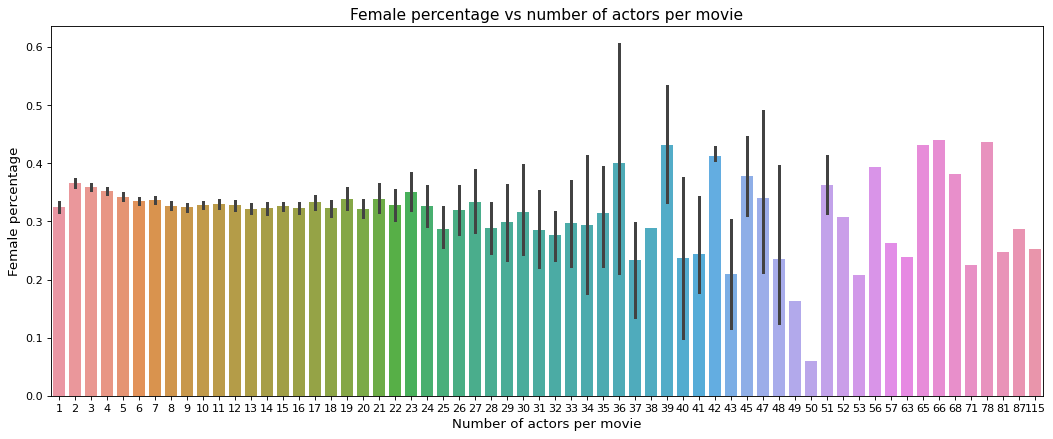

In [15]:
#plot a figure showing the percentage of female actors based on the number of actors in each movie
plt.figure(figsize=(16, 6), dpi=80)
ax = sns.barplot(x="Actor counts", y="Actor gender", data=fig_df)
plt.xlabel('Number of actors per movie', fontsize=12)
plt.ylabel('Female percentage', fontsize= 12)
plt.title('Female percentage vs number of actors per movie', fontsize= 14)

#### **Comment**

As we increase the number of characters, since the samples are small we see an increase in the confidence intervalls suggesting that the data are unreliable.
Moreover, the percentage of female actors stay more or less the same as the number of actors per movie increases except in the highest value of actors per movie. But as there is no interval of confidence meaning that there is not enough data to be conclusive.

In [16]:
#get the most reliable data (movies with less than 25 actors)
reliable_actors_df = fig_df[fig_df['Actor counts'] < 25]

In [17]:
#Using a pearson and spearman correlation to show if they are correlated
stats.pearsonr(reliable_actors_df['Actor counts'],reliable_actors_df['Actor gender'])

(-0.02828590623961351, 1.0669401396478728e-12)

In [18]:
stats.spearmanr(reliable_actors_df['Actor counts'],reliable_actors_df['Actor gender'])

SpearmanrResult(correlation=0.06658959745515668, pvalue=3.382213310507635e-63)

#### **Comment**

Even though the p-values of the pearson and spearman are less than 0.05 which says that we reject the null hypothesis and that the correlation between the two variables is statistically significant, the correlation values of both methods are really small. So we have a really small negative correlation between the number of actors in the movie and the female proportion. In other words, it shows that for bigger casts, there is less women proportionally (however really weak correlation) 

## Analysis of gender repartition over the movie run-time

In [19]:
#Select smaller data frame with only the columns we need
df_runtime = char_movie[['Freebase movie ID','Freebase actor ID', 'Actor gender','Movie runtime']]
#remove rows that have null values in the 'Movie runtime' column
df_runtime.dropna(subset=['Movie runtime'], inplace=True)
#remove 0.1% of the rows with the highest and lowest runtime as they are outliers
df_runtime = df_runtime[df_runtime['Movie runtime'] > df_runtime['Movie runtime'].quantile(0.001)]
df_runtime = df_runtime[df_runtime['Movie runtime'] < df_runtime['Movie runtime'].quantile(0.999)]
#create a df with movie runtimes and the corresponding male and female counts for that runtime
runtime_gender = df_runtime.groupby('Movie runtime').agg(Female_counts = ('Actor gender', lambda x: (x == 'F').sum()),
                                                         Male_counts = ('Actor gender', lambda x: (x == 'M').sum())).reset_index()


c:\Users\stavr\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


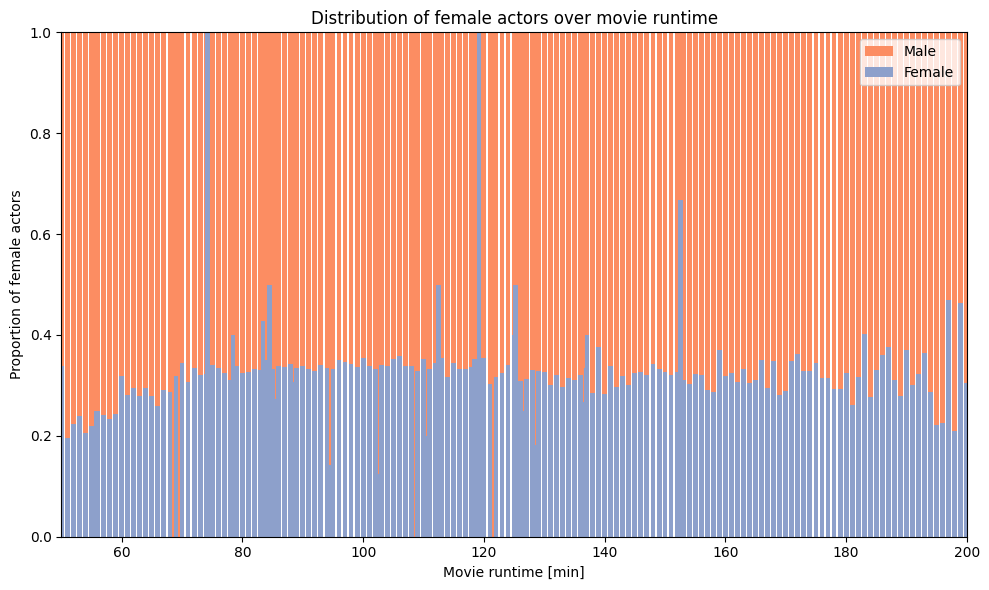

In [20]:
#plot the number of female and male counts over the runtime of each movie
fig, ax = plt.subplots(figsize=(10,6), sharey=True)
bar1 = ax.bar(runtime_gender['Movie runtime'], runtime_gender['Male_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']), 
              label = 'Male', color='#fc8d62', bottom = runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']))
bar2 = ax.bar(runtime_gender['Movie runtime'], runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']) 
              , label = 'Female', color='#8da0cb',)

ax.set_xlabel('Movie runtime [min]')

ax.set_ylabel('Proportion of female actors')
ax.set_title('Distribution of female actors over movie runtime')
ax.set_xbound(lower=50, upper=200)
ax.legend()
plt.tight_layout()
plt.show()

#### **Comment**

We see the same distribution between male and female actors for different movie runtimes, with females being around half or less than the males as our dataset have generally more males than females. Therefor the factor of the movie runtime does not show much variation of gender repartition.
The spikes that appear are attributed to some outlier data points.

In [21]:
#Using a pearson and spearman correlation to show that they are not correlated
stats.pearsonr(runtime_gender['Movie runtime'],runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']))

(-0.013425078010734736, 0.7998870884279242)

In [22]:
stats.spearmanr(runtime_gender['Movie runtime'],runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']))

SpearmanrResult(correlation=-0.019000269286903192, pvalue=0.7197592290163861)

#### **Comment**

The spearman and pearson correlation confirm that there is no significant correlation between the runtime and then female proportion of actors (p-value > 0.05 - we cannot reject the null hypothesis that there is no significant statistical correlation between movie runtime and female proportion)

## Analysis of gender repartition over the years

In [23]:
df_gender_year_copy = char_movie.copy()
#change date format for the year only
df_gender_year_copy['Movie release date_x']=pd.to_datetime(df_gender_year_copy['Movie release date_x'], errors='coerce', utc=True)
df_gender_year_copy['Movie release date_x']=df_gender_year_copy['Movie release date_x'].dt.year.dropna().astype(int)
df_gender_year_old = df_gender_year_copy[df_gender_year_copy['Movie release date_x'] <= 1915]
df_gender_year_new = df_gender_year_copy[df_gender_year_copy['Movie release date_x'] > 1915]
female_counts_1915 = df_gender_year_old['Actor gender'].value_counts(normalize=True).get('F', 0)
female_counts_new = df_gender_year_new['Actor gender'].value_counts(normalize=True).get('F', 0)

df_gender_year_last = df_gender_year_copy[df_gender_year_copy['Movie release date_x'] >2012]
df_gender_year_mid = df_gender_year_copy[df_gender_year_copy['Movie release date_x'] <= 2012]
female_counts_last = df_gender_year_last['Actor gender'].value_counts(normalize=True).get('F', 0)
female_counts_mid = df_gender_year_mid['Actor gender'].value_counts(normalize=True).get('F', 0)

print('Percentage of female actors for movies made before 1915 in respect to all the years', female_counts_1915/female_counts_new,'%')
print('Percentage of female actors for movies made after 2012 in respect to all the years', female_counts_last/female_counts_mid,'%')

Percentage of female actors for movies made before 1915 in respect to all the years 1.1198435547098513 %
Percentage of female actors for movies made after 2012 in respect to all the years 0.9211666988350677 %


Since there are less than 2% of female actors for the years before 1915 and after 2012 we discard these values 

In [24]:
#For each genre create a new subplot
df_year = char_movie.copy()
#change date format for the year only
df_year['Movie release date_x']=pd.to_datetime(df_year['Movie release date_x'], errors='coerce', utc=True)
df_year['Movie release date_x']=df_year['Movie release date_x'].dt.year.dropna().astype(int)
#drop the last years  and the first years as they are not complete
df_year = df_year[(df_year['Movie release date_x'] < 2012)& (df_year['Movie release date_x'] > 1915)]
#aggregate the data based on the release year
df_gender_year = df_year.groupby('Movie release date_x').agg(Female_counts = ('Actor gender', lambda x: (x == 'F').sum()),
                                                         Male_counts = ('Actor gender', lambda x: (x == 'M').sum()),
                                                         Female_perc = ('Actor gender', lambda x: (x == 'F').sum()/x.count()),
                                                         Male_perc = ('Actor gender', lambda x: (x == 'M').sum()/x.count()),
                                                         Female_means = ('Actor gender', lambda x: (x == 'F').mean()),
                                                         Male_means = ('Actor gender', lambda x: (x == 'M').mean()),
                                                         Female_std = ('Actor gender', lambda x: (x == 'F').std()),
                                                         Male_std = ('Actor gender', lambda x: (x == 'M').std())).reset_index()


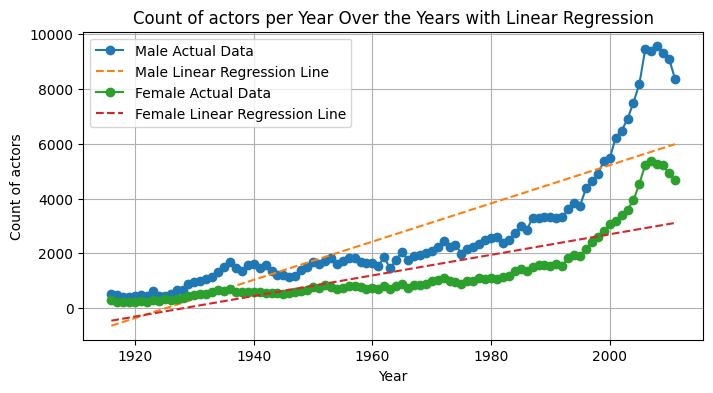

In [25]:
years = df_gender_year['Movie release date_x'].values.reshape(-1,1)
male_count_year_r = df_gender_year['Male_counts'].values
female_count_year_r = df_gender_year['Female_counts'].values

#linear regression for the count of actors for each year
regression = LinearRegression()
regression.fit(years, male_count_year_r)

regression_f = LinearRegression()
regression_f.fit(years, female_count_year_r)

# Make predictions using the linear model
predicted_character_counts = regression.predict(years)
predicted_character_counts_f = regression_f.predict(years)

plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.plot(years, male_count_year_r, marker='o', linestyle='-', label='Male Actual Data')
plt.plot(years, predicted_character_counts, linestyle='--', label='Male Linear Regression Line')

plt.plot(years, female_count_year_r, marker='o', linestyle='-', label='Female Actual Data')
plt.plot(years, predicted_character_counts_f, linestyle='--', label='Female Linear Regression Line')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count of actors')
plt.title('Count of actors per Year Over the Years with Linear Regression')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

r_squared = r2_score(male_count_year_r, predicted_character_counts)
r_squared_f = r2_score(female_count_year_r, predicted_character_counts_f)



X_male = sm.add_constant(years)
X_female = sm.add_constant(years)  # Add a constant term for the intercept
model_male = sm.OLS(male_count_year_r, X_male).fit()
model_female = sm.OLS(female_count_year_r, X_female).fit()




In [26]:
# Print the linear regression results for males
print("Linear Regression results for males:")
print(model_male.summary())

Linear Regression results for males:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     225.1
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           1.10e-26
Time:                        19:07:02   Log-Likelihood:                -820.80
No. Observations:                  96   AIC:                             1646.
Df Residuals:                      94   BIC:                             1651.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.3

In [27]:
# Print the linear regression results for females
print("Linear Regression results for females:")
print(model_female.summary())

Linear Regression results for females:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     174.6
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           3.73e-23
Time:                        19:07:02   Log-Likelihood:                -773.54
No. Observations:                  96   AIC:                             1551.
Df Residuals:                      94   BIC:                             1556.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7

#### **Comment**

Only the years between 1915 and 2012 are selected because the other years did not have enough data or were incomplete
We tried to see the trend of the evolution of the actor population per gender over the years with a linear regression. But the evolution of the male and female population of actors over the years getting exponential does not allow to be represented perfectly by a line, indeed the R-squared values are 0.65 for females and 0.71 for males.
However it still allows us to observe that the slope of the male population is higher than the female. Meaning that the population of male actors increased faster over the last decades.

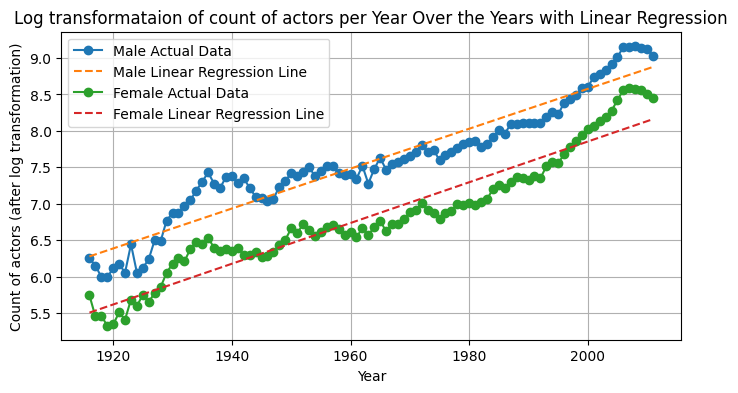

In [28]:
years = df_gender_year['Movie release date_x'].values.reshape(-1,1)
male_count_year_r = np.log(df_gender_year['Male_counts'].values)
female_count_year_r = np.log(df_gender_year['Female_counts'].values)

#linear regression for the count of actors for each year
regression = LinearRegression()
regression.fit(years, male_count_year_r)

regression_f = LinearRegression()
regression_f.fit(years, female_count_year_r)

# Make predictions using the linear model
predicted_character_counts = regression.predict(years)
predicted_character_counts_f = regression_f.predict(years)

plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.plot(years, male_count_year_r, marker='o', linestyle='-', label='Male Actual Data')
plt.plot(years, predicted_character_counts, linestyle='--', label='Male Linear Regression Line')

plt.plot(years, female_count_year_r, marker='o', linestyle='-', label='Female Actual Data')
plt.plot(years, predicted_character_counts_f, linestyle='--', label='Female Linear Regression Line')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count of actors (after log transformation)')
plt.title('Log transformataion of count of actors per Year Over the Years with Linear Regression')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

r_squared = r2_score(male_count_year_r, predicted_character_counts)
r_squared_f = r2_score(female_count_year_r, predicted_character_counts_f)



X_male = sm.add_constant(years)
X_female = sm.add_constant(years)  # Add a constant term for the intercept
model_male = sm.OLS(male_count_year_r, X_male).fit()
model_female = sm.OLS(female_count_year_r, X_female).fit()


In [29]:
# Print the linear regression results for males
print("Linear Regression results for males:")
print(model_male.summary())

Linear Regression results for males:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     957.6
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           4.42e-51
Time:                        19:07:02   Log-Likelihood:                 1.7759
No. Observations:                  96   AIC:                            0.4482
Df Residuals:                      94   BIC:                             5.577
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -4

In [30]:
# Print the linear regression results for females
print("Linear Regression results for females:")
print(model_female.summary())

Linear Regression results for females:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     996.4
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           8.01e-52
Time:                        19:07:02   Log-Likelihood:                 1.6782
No. Observations:                  96   AIC:                            0.6436
Df Residuals:                      94   BIC:                             5.772
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

#### Comment 

After doing a log transform of the dependent variable (count of actors), we observe that the linear regression fit the curves way better than without the log transform (as R-squared values are higher than 0.9 for both female and male lines). Moreover we can see that the slope of the two lines is approximately the same, which means for each year we get the same increase in percentage for male and female actors. However, as the counts of male actors are higher, then the same percentage change mean higher increase in absolute values of male actors than female actors

## Analysis of the proportion of actresses over the years
We observed the distribution of the actors per years over the time but let's now observe the evolution of the proportion of the actresses over the years

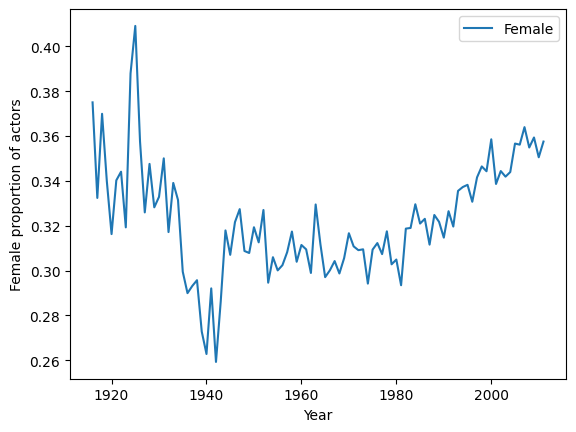

In [31]:
#plotting the percentages of female actors over the years
# Calculate yearly stats across movies here
plt.plot(df_gender_year['Movie release date_x'], df_gender_year['Female_perc'],
             label = 'Female')
plt.xlabel('Year')
plt.ylabel('Female proportion of actors')
plt.legend()
plt.show()

#### **Comment**

From this last graph we can see that the evolution of the proportion of female actors has two different trends with a shift around 1940.
It would be interesting for the next steps of the project to study the historical events that influence this evolution and to observe per country how the history has marked the evolution of the place of the women in the cinema

In [32]:
#correlation between the year and the female proportion for the two discrete time periods
df_gender_before_1941 = df_gender_year[df_gender_year['Movie release date_x'] <= 1941]
df_gender_after_1941 = df_gender_year[df_gender_year['Movie release date_x'] > 1941]

In [33]:
stats.pearsonr(df_gender_before_1941['Movie release date_x'], df_gender_before_1941['Female_perc'])

(-0.6996904476681935, 6.944384574613809e-05)

In [34]:
stats.spearmanr(df_gender_before_1941['Movie release date_x'], df_gender_before_1941['Female_perc'])

SpearmanrResult(correlation=-0.7005128205128205, pvalue=6.751836003774529e-05)

#### **Comment**

So we see a strong, negative, statistically significant correlation between the female proportion of the actors and the year, for the years before 1941 (negative correlation close to 1, p-value<0.05 - reject the null hypothesis that there is no signigicant statistical correlation between the year and female proportion)

In [35]:
stats.pearsonr(df_gender_after_1941['Movie release date_x'], df_gender_after_1941['Female_perc'])

(0.7687060398392583, 7.870639868070475e-15)

In [36]:
stats.spearmanr(df_gender_after_1941['Movie release date_x'], df_gender_after_1941['Female_perc'])

SpearmanrResult(correlation=0.7260432158166389, pvalue=1.1446446124274574e-12)

#### **Comment**

After the year 1941, as shown on the above graph, the reverse is shown. There is a strong, positive, significant correlation between the year and the female proportion of the actors (positive correlation close to 1, p-value<0.05 - reject the null hypothesis that there is no signigicant statistical correlation between the year and female proportion).

## Analysis of the proportion of female for each month

In [37]:
#Make a dataframe with the movie release date and the actor gender
gender_month = char_movie[['Freebase movie ID','Freebase actor ID','Movie release date_x','Actor gender']]
#describe the dataframe
gender_month.describe()

,Freebase movie ID,Freebase actor ID,Movie release date_x,Actor gender
count,405060,405060,395214,405060
unique,63652,97383,18432,2
top,/m/0cc8620,/m/0c5vh,2006,M
freq,115,791,4223,270257


In [38]:
#change date format and create a new column with the month only
gender_month['Movie release date_x'] = pd.to_datetime(gender_month['Movie release date_x'], errors='coerce', utc=True)
gender_month['Movie release month'] = gender_month['Movie release date_x'].dt.month.dropna().astype(int)


C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
gender_month.head()

,Freebase movie ID,Freebase actor ID,Movie release date_x,Actor gender,Movie release month
0,/m/03vyhn,/m/03wcfv7,2001-08-24 00:00:00+00:00,F,8.0
1,/m/03vyhn,/m/0346l4,2001-08-24 00:00:00+00:00,F,8.0
2,/m/03vyhn,/m/01vw26l,2001-08-24 00:00:00+00:00,M,8.0
3,/m/03vyhn,/m/034hyc,2001-08-24 00:00:00+00:00,M,8.0
4,/m/03vyhn,/m/01y9xg,2001-08-24 00:00:00+00:00,F,8.0


In [40]:
#aggregate the data based on the month
gender_month_df = gender_month.groupby(['Movie release month']).agg(Female_counts = ('Actor gender', lambda x: (x == 'F').sum()),
                                                         Male_counts = ('Actor gender', lambda x: (x == 'M').sum()),
                                                         Female_perc = ('Actor gender', lambda x: (x == 'F').sum()/x.count()),
                                                         Male_perc = ('Actor gender', lambda x: (x == 'M').sum()/x.count()),).reset_index()

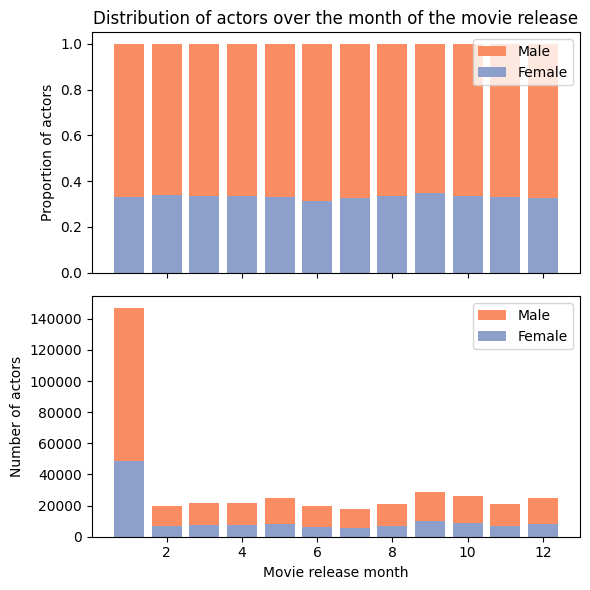

In [41]:
#plot the number of female and male counts over the runtime of each movie
fig, ax = plt.subplots(figsize=(6,6), sharex=True, nrows=2, ncols=1)
bar1 = ax[0].bar(gender_month_df['Movie release month'], 
              gender_month_df['Male_counts']/(gender_month_df['Male_counts']+gender_month_df['Female_counts']), 
              label = 'Male', color='#fc8d62', 
              bottom = gender_month_df['Female_counts']/(gender_month_df['Male_counts']+gender_month_df['Female_counts']))
bar2 = ax[0].bar(gender_month_df['Movie release month'], gender_month_df['Female_counts']/(gender_month_df['Male_counts']+gender_month_df['Female_counts']) 
              , label = 'Female', color='#8da0cb',)

#ax[0].set_xlabel('Actor age at movie release')

ax[0].set_ylabel('Proportion of actors')
ax[0].set_title('Distribution of actors over the month of the movie release')
ax[0].legend()

bar3 = ax[1].bar(gender_month_df['Movie release month'], 
              gender_month_df['Male_counts'], 
              label = 'Male', color='#fc8d62', 
              bottom = gender_month_df['Female_counts'])
bar4 = ax[1].bar(gender_month_df['Movie release month'], gender_month_df['Female_counts'], label = 'Female', color='#8da0cb',)
ax[1].set_xlabel('Movie release month')

ax[1].set_ylabel('Number of actors')
ax[1].legend()

plt.tight_layout()
plt.show()

#### **Comment**

We can see that most of the data are from the 1st month (January). We can also observe that there are no differences in the female proportion of the actors and the different months that the movies were released.

## Propensity score of covariates

Having in mind that we may need to do matching going forward, the propensity scores are calculated using logistic regression

In [42]:
#get the columns that we need as covariates
df_propensity = char_movie[['Freebase movie ID','Movie release date_x','Genres','Countries',
                            'Movie runtime', 'Actor age at movie release','Actor gender']]
print(df_propensity.shape)
print(df_propensity.isna().sum())

(405060, 7)
Freebase movie ID                  0
Movie release date_x            9846
Genres                             0
Countries                          0
Movie runtime                  48601
Actor age at movie release    114290
Actor gender                       0
dtype: int64


In [ ]:
#drop the null values
df_propensity.dropna(inplace=True)
#change date format for the year only
df_propensity['Movie release date_x']=pd.to_datetime(df_propensity['Movie release date_x'], errors='coerce', utc=True)
df_propensity['Movie release date_x']=df_propensity['Movie release date_x'].dt.year.dropna().astype(int)


In [44]:
# Function to safely convert string representations of lists into actual lists
def string_to_list(list_string):
    try:
        # This safely evaluates a string as a list
        return ast.literal_eval(list_string)
    except ValueError:
        # In case of error (e.g., empty strings), return an empty list
        return []

In [ ]:
# Transform the Genres and Countries to lists
df_propensity['Genres'] = df_propensity['Genres'].apply(string_to_list)
df_propensity['Countries'] = df_propensity['Countries'].apply(string_to_list)
# Transform the lists to tuples so they can be exploded
df_propensity['Genres'] = df_propensity['Genres'].apply(tuple)
df_propensity['Countries'] = df_propensity['Countries'].apply(tuple)
df_propensity.head()

In [46]:
df_propensity_exploded = df_propensity.explode('Genres')
df_propensity_exploded = df_propensity_exploded.explode('Countries')
df_propensity_exploded.shape

(1499283, 7)

In [48]:
#change the Gender column to 0 and 1
df_propensity_dummy['Actor gender'] = df_propensity_dummy['Actor gender'].apply(lambda x: 1 if x=='F' else 0)

In [47]:
#change the categorical variables to dummy variables
# One-hot encode the genres and countries variable
df_propensity_dummy = pd.get_dummies(df_propensity_exploded, columns=['Countries'], drop_first=True)
df_propensity_dummy = pd.get_dummies(df_propensity_dummy, columns=['Genres'], drop_first=True)
df_propensity_dummy.shape

(1499283, 492)

In [49]:
#Get the features in a new dataframe
df_propensity_dummy_features = df_propensity_dummy.drop(['Freebase movie ID','Actor gender'], axis=1)
#Get the target variable in a new dataframe
df_propensity_dummy_target = df_propensity_dummy['Actor gender']

#### Comment

The exploded dataframe has too many features to be used on logistic regression. So we will try to do the same but with just using the 10 highest countries and genres in terms of number of actors

In [50]:
columns_countries = df_propensity_dummy_features.filter(like = 'Countries') #select all columns with the word 'Countries'
columns_genres = df_propensity_dummy_features.filter(like = 'Genres') #select all columns with the word 'Genres'

column_sums_countries = columns_countries.sum() #sum the columns
column_sums_genres = columns_genres.sum() 
# Select the top 10 columns with the largest sum
top_10_columns_countries = column_sums_countries.nlargest(10).index
top_10_columns_genres = column_sums_genres.nlargest(10).index
# Create a new DataFrame with only the top 10 columns
df_countries_top_10 = columns_countries[top_10_columns_countries]
df_genres_top_10 = columns_genres[top_10_columns_genres]

#remove all the columns of countries and genres
df_propensity_dummy_features_top_10 = df_propensity_dummy_features.iloc[:,0:3]
df_propensity_dummy_features_top_10 = pd.concat([df_propensity_dummy_features_top_10, df_countries_top_10, df_genres_top_10], axis=1)
df_propensity_dummy_features_top_10.head()

,Movie release date_x,Movie runtime,Actor age at movie release,Countries_United States of America,Countries_United Kingdom,Countries_France,Countries_India,Countries_Germany,Countries_Japan,Countries_Canada,...,Genres_Drama,Genres_Comedy,Genres_Thriller,Genres_Romance Film,Genres_Action,Genres_World cinema,Genres_Action/Adventure,Genres_Crime Fiction,Genres_Adventure,Genres_Indie
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Fit a logistic regression model to estimate propensity scores
model = LogisticRegression()
model.fit(df_propensity_dummy_features_top_10, df_propensity_dummy_target)

# Get the predicted propensity scores for the synthetic data
propensity_scores = model.predict_proba(df_propensity_dummy_features_top_10)[:, 1]


# Display the first few rows of the data with propensity scores and gender indicator
print(propensity_scores)

# Add propensity scores and gender indicator to the data
df_propensity_scores = pd.concat([df_propensity_dummy_features_top_10, df_propensity_dummy_target], axis=1)
df_propensity_scores['propensity_score'] = propensity_scores
df_propensity_scores.head()

[0.29253572 0.29254069 0.29254069 ... 0.4215825  0.42159793 0.53175558]


,Movie release date_x,Movie runtime,Actor age at movie release,Countries_United States of America,Countries_United Kingdom,Countries_France,Countries_India,Countries_Germany,Countries_Japan,Countries_Canada,...,Genres_Thriller,Genres_Romance Film,Genres_Action,Genres_World cinema,Genres_Action/Adventure,Genres_Crime Fiction,Genres_Adventure,Genres_Indie,Actor gender,propensity_score
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.292536
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.292541
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.292541
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0.292533
0,2001,98.0,42.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.292541
